# Option Pricing

Let's start by defining an asset at $t=0$ with price $S=100$£, average rate of return $r=12$% and volatility $\sigma=20$%.

In [1]:
import option
import numpy as np
import matplotlib.pyplot as plt


S = 100.0
r = 0.12
sigma = 0.2
asset = option.Asset(S,sigma)

First, let's see how the asset price is going to change in the next year ($t=1$ year). Since the change in the price is stochastic, we simulate 5 different random scenarios.

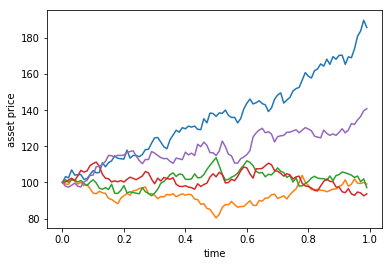

In [2]:
t = 1.0
asset.sim_plot(r, t, num_sim=5)

Due to the stochastic nature of asset price movement, everytime we run the above code we get different scenarios.
Now, let's define at the money European call and put options of this asset, with term $T=0.5$ years, and we choose the interest rate to be $r=12$%. 

In [3]:
T = 0.5
K = S #at the money option
call = option.EuropeanOption("Call", asset, K, T, r, "Analytic")
put = option.EuropeanOption("Put", asset, K, T, r, "Analytic")

The arguments are, respectively, the option type (Call or Put), the underlying asset of the option, strike, term, risk-free interest rate, and the last argument determines the main pricing method.
Evaluate the price of each option:

In [4]:
c = call.price()
p = put.price()
print("call option price: %2.3f£" %c)
print("put option price: %2.3f£" %p)

call option price: 8.869£
put option price: 3.046£


Let's check that put-call parity holds

In [5]:
print("p + S = %2.2f" % (put.price() + S))
print("c + K e^{-rT} = %2.2f" % (call.price() + K*np.exp(-r*T)))

p + S = 103.05
c + K e^{-rT} = 103.05


For each of these options, we can also calculate the value of Greeks. For the call option:

In [6]:
print("call delta: %2.3f" %call.delta())
print("call gamma: %2.3f" %call.gamma())
print("call vega: %2.3f" %call.vega())
print("call rho: %2.3f" %call.rho())
print("call theta: %2.3f" %call.theta())

call delta: 0.690
call gamma: 0.025
call vega: 0.251
call rho: 0.303
call theta: -0.033


For the put option:

In [7]:
print("put delta: %2.3f" %put.delta())
print("put gamma: %2.3f" %put.gamma())
print("put vega: %2.3f" %put.vega())
print("put rho: %2.3f" %put.rho())
print("put theta: %2.3f" %put.theta())


put delta: -0.310
put gamma: 0.025
put vega: 0.251
put rho: -0.167
put theta: -0.002


Finally, let's compare the accuracy of other pricing methods.
Binomial and Monte Carlo

In [8]:
acc_binomial_call = (call.binomial(step=500) - c)/c
print("call price relative error of binomial method with 500 steps: %2.5f" %acc_binomial_call)
acc_mc_call= (call.monte_carlo(number_simulation=10000, steps=200)-c)/c
print("call price relative error of Monte Carlo method \n",
      "with 10,000 simulations and 200 time-steps in each simulation = %2.5f"
      %acc_mc_call)
acc_binomial_put = (put.binomial(step=500) - p)/p
print("put price relative error of binomial method with 500 steps: %2.5f" %acc_binomial_put)
acc_mc_put= (put.monte_carlo(number_simulation=10000, steps=200)-p)/p
print("put price relative error of Monte Carlo method \n"
      "with 10,000 simulations and 200 time-steps in each simulation = %2.5f"
      %acc_mc_put)

call price relative error of binomial method with 500 steps: -0.00033
call price relative error of Monte Carlo method 
 with 10,000 simulations and 200 time-steps in each simulation = 0.02135
put price relative error of binomial method with 500 steps: -0.00097
put price relative error of Monte Carlo method 
with 10,000 simulations and 200 time-steps in each simulation = 0.00508


# Implied volatility

Another feaure of the code is to calculate the implied volatility of an option, given its price in the market.
Let's say that the European call option considered above is traded in the market with price $c_{market}=8$£. What is the implied volatility of the option then?
We can define a European call option (like above, though the value of volatility can be chosen arbitarily) and find the implied volatility of the option

In [9]:
c_market = 8.0 
print("implied volatility of the option is: %2.2f" %call.implied_vol(c_market))

implied volatility of the option is: 0.16


# American option

Similar to European option, we can define call and put American options.
Note that for American options the only pricing method is binomial, and it doesn't need to be specified explicitly.

In [10]:
Call = option.AmericanOption("Call", asset, K, T, r)
Put = option.AmericanOption("Put", asset, K, T, r)

In [11]:
C = Call.price()
P = Put.price()
print("American call option price %2.4f" %C)
print("American put option price %2.4f" %P)

American call option price 8.8677
American put option price 3.6701


Greeks can also be calculated, similar to European options.

# Asian option

Asian options are very similar to European options, with a simple modification that the asset price at maturity is replaced with the average of the asset price over a period of time before maturity, as we call it average period. 
For example, Consider our asset with $S=100$ and $\sigma=20$%. We can define at the money asian call and put options with term $T=0.5$ years with average period $T_{av}=1$ month. 
Note that an asian option in the limiting case, when $T_{av} \rightarrow 0$ is a European option.

In [12]:
T_av = 1/12.0
asian_call = option.AsianOption("Call", asset, K, T, r, T_av)
asian_put = option.AsianOption("Put", asset, K, T, r, T_av)

In [13]:
asian_c = asian_call.price()
asian_p = asian_put.price()
print("Asian call option price %2.4f" %asian_c)
print("Asian put option price %2.4f" %asian_p)

Asian call option price 8.2338
Asian put option price 2.9512


Comparing to their European counterparts, both asian put and call options are cheaper. One can interpret this result as follows: the averaging period effectively reduces the volatility of the payoff price at maturity and this reduces the price of the option.
In fact, we can numerically check this conjecture. If the above claim is correct, we expect the implied volatility of a European option with same price and characterisitics of the asian option reduces as the averaging period increases. The following plot shows this

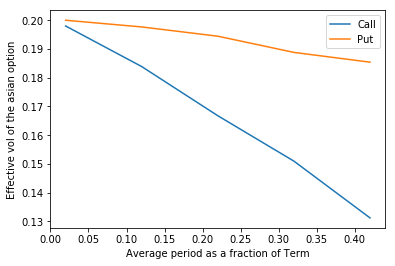

In [14]:
t_av = np.arange(0.01, T/2, T/10)
asian_call_eff_vol = []
asian_put_eff_vol = []
for t in t_av:
    # for a given average period calculate the price of the asian option
    asian_call = option.AsianOption("Call", asset, K, T, r, t)
    asian_put = option.AsianOption("Put", asset, K, T, r, t)
    # calculate the implied volatility of a European option with same characterisitics and price
    asian_call_eff_vol.append(asian_call.effective_vol())
    asian_put_eff_vol.append(asian_put.effective_vol())
plt.plot(t_av/T, asian_call_eff_vol, label="Call")
plt.plot(t_av/T, asian_put_eff_vol, label="Put")
plt.legend()
plt.xlabel("Average period as a fraction of Term")
plt.ylabel("Effective vol of the asian option")
plt.show()